# Xarray for multidimensional gridded data

In last week's lecture, we saw how Pandas provided a way to keep track of additional "metadata" surrounding tabular datasets, including "indexes" for each row and labels for each column. These features, together with Pandas' many useful routines for all kinds of data munging and analysis, have made Pandas one of the most popular python packages in the world.

However, not all Earth science datasets easily fit into the "tabular" model (i.e. rows and columns) imposed by Pandas. In particular, we often deal with _multidimensional data_. By _multidimensional data_ (also often called _N-dimensional_), I mean data with many independent dimensions or axes. For example, we might represent Earth's surface temperature $T$ as a three dimensional variable

$$ T(x, y, t) $$

where $x$ is longitude, $y$ is latitude, and $t$ is time.

The point of xarray is to provide pandas-level convenience for working with this type of data. 



![xarray data model](https://github.com/pydata/xarray/raw/master/doc/_static/dataset-diagram.png)

**NOTE:** In order to run this tutorial, you need `xarray` and `netCDF4` packages installed. The best thing to do is to create a custom conda environment, as described on the [python installation page](https://rabernat.github.io/research_computing/python.html) (scroll to Geosciences Python Environment). To test whether your environment is set up properly, try the following imports:

In [1]:
import xarray
import netCDF4

## Xarray data structures

Like Pandas, xarray has two fundamental data structures:
* a `DataArray`, which holds a single multi-dimensional variable and its coordinates
* a `Dataset`, which holds multiple variables that potentially share the same coordinates

### DataArray

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

Let's start by constructing some DataArrays manually 

In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

A simple DataArray without dimensions or coordinates isn't much use.

In [3]:
da = xr.DataArray([9, 0, 2, 1, 0])
da

<xarray.DataArray (dim_0: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: dim_0

We can add a dimension name...

In [4]:
da = xr.DataArray([9, 0, 2, 1, 0], dims=['x'])
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: x

But things get most interesting when we add a coordinate:

In [6]:
da = xr.DataArray([9, 0, 2, 1, 0],
                  dims=['x'],
                  coords={'x': [10, 20, 30, 40, 50]})
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Coordinates:
  * x        (x) int64 10 20 30 40 50

Xarray has built-in plotting, like pandas.

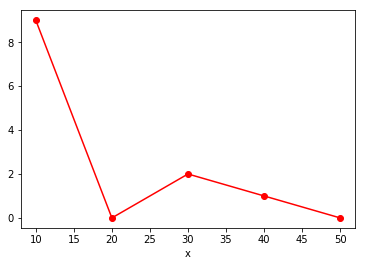

In [12]:
da.plot(marker='o',color='r')

### Multidimensional DataArray

If we are just dealing with 1D data, Pandas and Xarray have very similar capabilities. Xarray's real potential comes with multidimensional data.

Let's go back to the multidimensional ARGO data we loaded in the numpy lession. If you haven't already downloaded it, you can do so at the command line with

```shell
curl -O http://www.ldeo.columbia.edu/~rpa/argo_float_4901412.npz
```

We reload this data and examine its keys.

In [13]:
argo_data = np.load('argo_float_4901412.npz')
argo_data.keys()

['S', 'T', 'levels', 'lon', 'date', 'P', 'lat']

The values of the `argo_data` object are numpy arrays.

In [18]:
argo_data['levels']



array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77])

In [20]:
S = argo_data.f.S
T = argo_data.f.T
P = argo_data.f.P
levels = argo_data.f.levels
lon = argo_data.f.lon
lat = argo_data.f.lat
date = argo_data.f.date
print(S.shape, lon.shape, lat.shape, date.shape, levels.shape)

(78, 75) (75,) (75,) (75,) (78,)


Let's organize the data and coordinates of the salinity variable into a DataArray.

In [21]:
da_salinity = xr.DataArray(S, dims=['level', 'date'],
                           coords={'level': levels,
                                   'date': date},)
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.638939, 35.514957, 35.572971, ..., 35.820938, 35.777939, 35.668911],
       [35.633938, 35.521957, 35.573971, ..., 35.810932, 35.583897, 35.667912],
       [35.681946, 35.525959, 35.572971, ..., 35.795929, 35.662907, 35.665913],
       ...,
       [34.915859, 34.923904, 34.923904, ..., 34.934811, 34.940811, 34.946808],
       [34.915859, 34.923904, 34.921906, ..., 34.932808, 34.93681 , 34.94381 ],
       [34.917858, 34.923904, 34.923904, ...,       nan, 34.93681 ,       nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ...

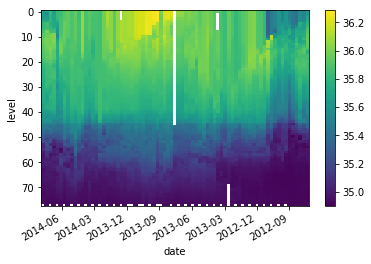

In [25]:
da_salinity.plot(yincrease=False, xincrease=False)

Attributes can be used to store metadata. What metadata should you store? The [CF Conventions](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#_description_of_the_data) are a great resource for thinking about climate metadata. Below we define two of the required CF-conventions attributes.

In [26]:
da_salinity.attrs['units'] = 'PSU'
da_salinity.attrs['standard_name'] = 'sea_water_salinity'
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.638939, 35.514957, 35.572971, ..., 35.820938, 35.777939, 35.668911],
       [35.633938, 35.521957, 35.573971, ..., 35.810932, 35.583897, 35.667912],
       [35.681946, 35.525959, 35.572971, ..., 35.795929, 35.662907, 35.665913],
       ...,
       [34.915859, 34.923904, 34.923904, ..., 34.934811, 34.940811, 34.946808],
       [34.915859, 34.923904, 34.921906, ..., 34.932808, 34.93681 , 34.94381 ],
       [34.917858, 34.923904, 34.923904, ...,       nan, 34.93681 ,       nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ...
Attributes:
    units:          PSU
    standard_name:  sea_water_salinity

### Datasets

A Dataset holds many DataArrays which potentially can share coordinates. In analogy to pandas:

    pandas.Series : pandas.Dataframe :: xarray.DataArray : xarray.Dataset
    
Constructing Datasets manually is a bit more involved in terms of syntax. The Dataset constructor takes three arguments:

* `data_vars` should be a dictionary with each key as the name of the variable and each value as one of:
  * A `DataArray` or Variable
  * A tuple of the form `(dims, data[, attrs])`, which is converted into arguments for Variable
  * A pandas object, which is converted into a `DataArray`
  * A 1D array or list, which is interpreted as values for a one dimensional coordinate variable along the same dimension as it’s name
* `coords` should be a dictionary of the same form as data_vars.
* `attrs` should be a dictionary.

Let's put together a Dataset with temperature, salinity and pressure all together

In [27]:
argo = xr.Dataset(
        data_vars={'salinity':    (('level', 'date'), S),
                   'temperature': (('level', 'date'), T),
                   'pressure':    (('level', 'date'), P)},
        coords={'level': levels,
                'date': date})
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ...
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 35.45 35.5 ...
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 19.15 19.84 ...
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 5.9 6.8 5.4 6.3 6.2 ...

What about lon and lat? We forgot them in the creation process, but we can add them after the fact.

In [28]:
argo['lon'] = lon
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78, lon: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ...
  * lon          (lon) float64 -39.13 -37.28 -36.9 -36.89 -37.05 -36.66 ...
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 35.45 35.5 ...
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 19.15 19.84 ...
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 5.9 6.8 5.4 6.3 6.2 ...

That was not quite right...we want lon to have dimension `date`:

In [30]:
del argo['lon']
argo['lon'] = ('date', lon)
argo['lat'] = ('date', lat)
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ...
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 35.45 35.5 ...
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 19.15 19.84 ...
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 5.9 6.8 5.4 6.3 6.2 ...
    lat          (date) float64 47.19 46.72 46.45 46.23 45.46 44.83 44.45 ...
    lon          (date) float64 -39.13 -37.28 -36.9 -36.89 -37.05 -36.66 ...

### Coordinates vs. Data Variables

Data variables can be modified through arithmentic operations or other functions. Coordinates are always keept the same.

In [31]:
argo * 10000

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ...
  * level        (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    salinity     (level, date) float64 3.564e+05 3.551e+05 3.557e+05 ...
    temperature  (level, date) float64 1.897e+05 1.844e+05 1.91e+05 ...
    pressure     (level, date) float64 6.8e+04 6.1e+04 6.5e+04 5e+04 5.9e+04 ...
    lat          (date) float64 4.719e+05 4.672e+05 4.645e+05 4.623e+05 ...
    lon          (date) float64 -3.913e+05 -3.728e+05 -3.69e+05 -3.689e+05 ...

Clearly lon and lat are coordinates rather than data variables. We can change their status as follows:

In [32]:
argo = argo.set_coords(['lon', 'lat'])
argo

<xarray.Dataset>
Dimensions:      (date: 75, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ...
    lat          (date) float64 47.19 46.72 46.45 46.23 45.46 44.83 44.45 ...
    lon          (date) float64 -39.13 -37.28 -36.9 -36.89 -37.05 -36.66 ...
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 35.45 35.5 ...
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 19.15 19.84 ...
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 5.9 6.8 5.4 6.3 6.2 ...

The `*` symbol in the representation above indicates that `level` and `date` are "dimension coordinates" (they describe the coordinates associated with data variable axes) while `lon` and `lat` are "non-dimension coordinates". We can make any variable a non-dimension coordiante.

## Working with Labeled Data

Xarray's labels make working with multidimensional data much easier.

### Selecting Data (Indexing)

We can always use regular numpy indexing and slicing on DataArrays

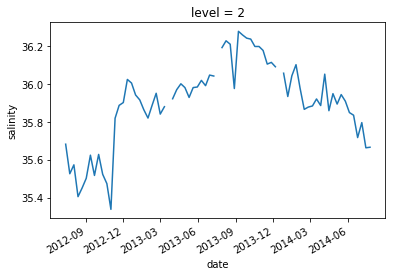

In [33]:
argo.salinity[2].plot()

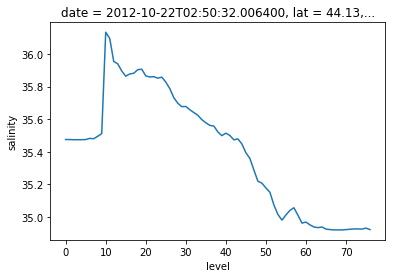

In [34]:
argo.salinity[:, 10].plot()

However, it is often much more powerful to use xarray's `.sel()` method to use label-based indexing.

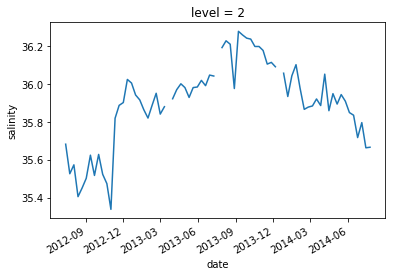

In [35]:
argo.salinity.sel(level=2).plot()

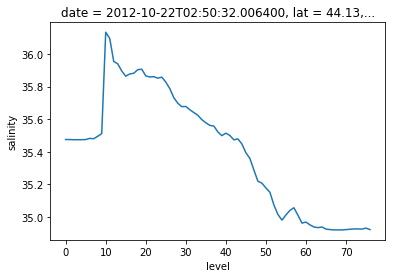

In [36]:
argo.salinity.sel(date='2012-10-22').plot()

`.sel()` also supports slicing. Unfortunately we have to use a somewhat awkward syntax, but it still works.

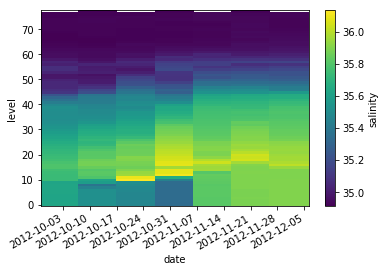

In [37]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01')).plot()

`.sel()` also works on the whole Dataset

In [38]:
argo.sel(date='2012-10-22')

<xarray.Dataset>
Dimensions:      (date: 1, level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * date         (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lat          (date) float64 44.13
    lon          (date) float64 -32.97
Data variables:
    salinity     (level, date) float64 35.47 35.47 35.47 35.47 35.47 35.47 ...
    temperature  (level, date) float64 17.13 17.13 17.13 17.13 17.14 17.14 ...
    pressure     (level, date) float64 6.4 10.3 15.4 21.0 26.0 30.2 35.4 ...

### Computation

Xarray dataarrays and datasets work seamlessly with arithmetic operators and numpy array functions.

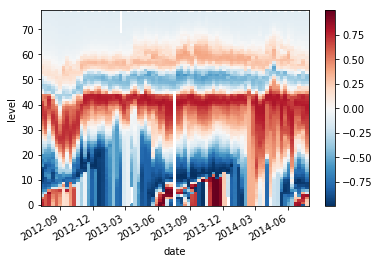

In [41]:
α = np.cos(argo.temperature) * np.sin(argo.salinity)**2 
α.plot()


### Broadcasting

Broadcasting arrays in numpy is a nightmare. It is much easier when the data axes are labeled!

This is a useless calculation, but it illustrates how perfoming an operation on arrays with differenty coordinates will result in automatic broadcasting

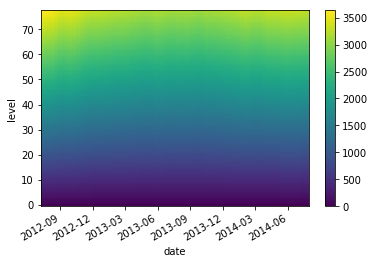

In [42]:
level_times_lat = argo.level * argo.lat
level_times_lat.plot()

### Reductions

Rather than performing reductions on axes (as in numpy), we can perform them on dimensions.

In [43]:
argo_mean = argo.mean(dim='date')
argo_mean

<xarray.Dataset>
Dimensions:      (level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    salinity     (level) float64 35.91 35.9 35.9 35.9 35.91 35.91 35.91 ...
    temperature  (level) float64 17.6 17.57 17.51 17.42 17.25 17.04 16.77 ...
    pressure     (level) float64 6.435 10.57 15.54 20.46 25.43 30.44 35.44 ...

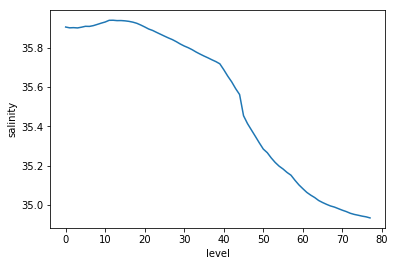

In [44]:
argo_mean.salinity.plot()

### Aside: Swapping Dims

Now we can fix a pesky problem with this dataset: the fact that it uses level (rather than pressure) as the vertical coordinate

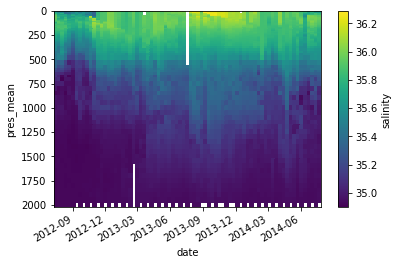

In [45]:
argo['pres_mean'] = argo_mean.pressure
argo_pcoords = argo.swap_dims({'level': 'pres_mean'})
argo_pcoords.salinity.plot(yincrease=False)

## Groupby: Example with SST Climatology

Here will we work with SST data from NOAA's NERSST project. Download it by running

```shell
curl -O http://ldeo.columbia.edu/~rpa/NOAA_NCDC_ERSST_v3b_SST.nc
```

In [47]:
ds = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 1960-03-15 ...
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [48]:
sst = ds.sst
type(sst)

xarray.core.dataarray.DataArray

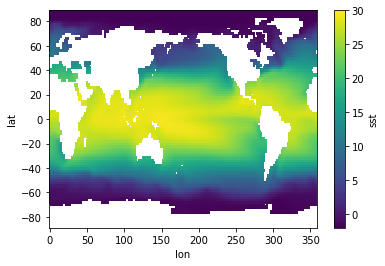

In [49]:
sst.mean(dim='time').plot(vmin=-2, vmax=30)

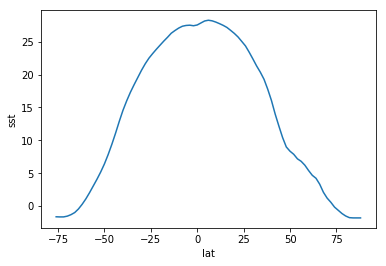

In [50]:
sst.mean(dim=('time', 'lon')).plot()

In [51]:
sst_zonal_time_mean = sst.mean(dim=('time', 'lon'))

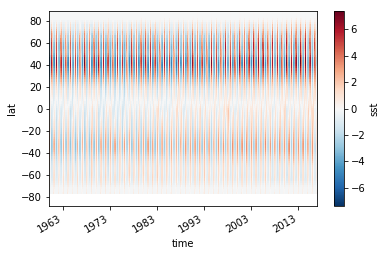

In [52]:
(sst.mean(dim='lon') - sst_zonal_time_mean).T.plot()

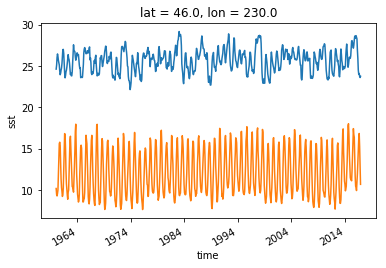

In [53]:
#sst.sel(lon=200, lat=0).plot()
sst.sel(lon=230, lat=0, method='nearest').plot()
sst.sel(lon=230, lat=45, method='nearest').plot()

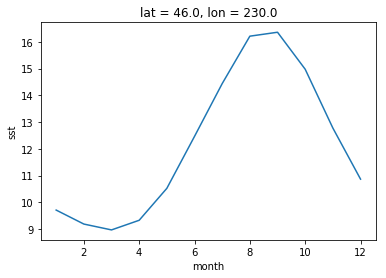

In [54]:
# climatologies
sst_clim = sst.groupby('time.month').mean(dim='time')
sst_clim.sel(lon=230, lat=45, method='nearest').plot()

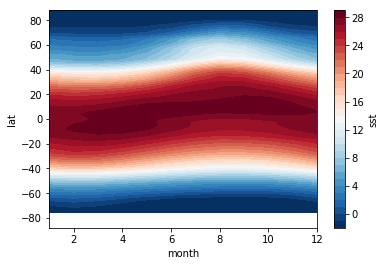

In [58]:
sst_clim.mean(dim='lon').T.plot.contourf(levels=np.arange(-2,30))

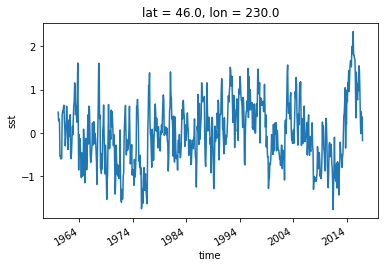

In [59]:
sst_anom = sst.groupby('time.month') - sst_clim
sst_anom.sel(lon=230, lat=45, method='nearest').plot()

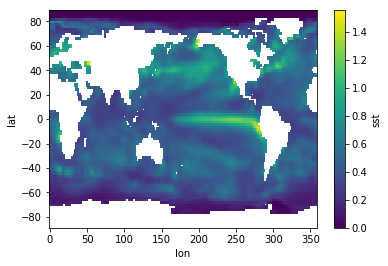

In [60]:
sst_anom.std(dim='time').plot()

https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php
    
El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

![nino-regions](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)

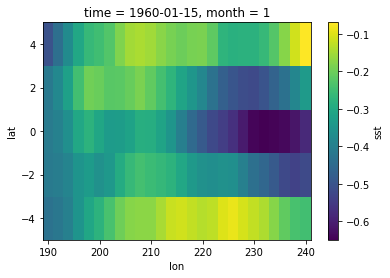

In [61]:
sst_anom_nino34 = sst_anom.sel(lat=slice(-5, 5), lon=slice(190, 240))
sst_anom_nino34[0].plot()

In [72]:
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3, center=True).mean(dim='time')

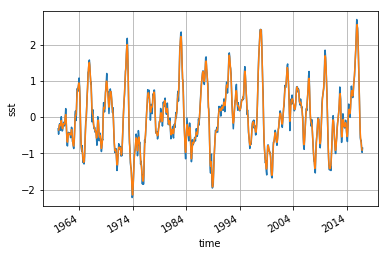

In [73]:
fig, ax = plt.subplots()
sst_anom_nino34_mean.plot(ax=ax, label='raw')
oni.plot(ax=ax, label='smoothed')
ax.grid()

![nino3.4](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)


In [74]:
# create a categorical  dataarray
nino34 = xr.full_like(oni, 'none', dtype='U4')
nino34[oni >= 0.5] = 'nino'
nino34[oni <= -0.5] = 'nina'
nino34

<xarray.DataArray (time: 684)>
array(['none', 'none', 'none', ..., 'nina', 'nina', 'none'], dtype='<U4')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 1960-03-15 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...

In [75]:
sst_nino_composite = sst_anom.groupby(nino34.rename('nino34')).mean(dim='time')

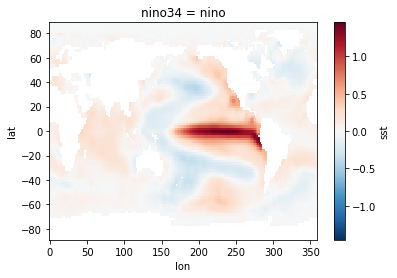

In [76]:
sst_nino_composite.sel(nino34='nino').plot()

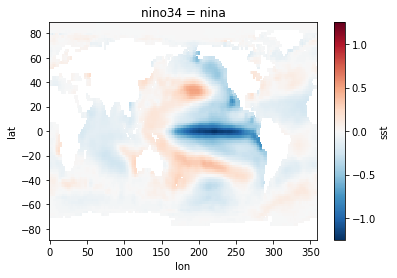

In [77]:
sst_nino_composite.sel(nino34='nina').plot()

In [78]:
nino_ds = xr.Dataset({'nino34': nino34, 'oni': oni}).drop('month')
nino_ds.to_netcdf('nino34_index.nc')